In [1]:
import torch.jit
import time
from argparse import ArgumentParser
import numpy as np
import torch

import dlrm.scripts.utils as utils
from dlrm.data.data_loader import get_data_loaders
from dlrm.data.utils import get_categorical_feature_sizes, prefetcher
from dlrm.model.single import Dlrm
from dlrm.utils.checkpointing.serial import SerialCheckpointWriter, make_serial_checkpoint_writer, \
    make_serial_checkpoint_loader

Using the Volta-optimized dot interaction kernels


In [2]:
!cat /data/dlrm/binary_dataset/model_size.json

{
    "_c2": 138493,
    "_c3": 26744
}

In [3]:
import pandas as pd

users_mapping = pd.read_parquet('/mnt/dldata/vinhn/DeepLearningExamples/PyTorch/Recommendation/DLRM/data/dlrm/spark/output/models/2.parquet',engine='pyarrow')

In [4]:
users_mapping.shape

(138493, 3)

In [5]:
users_mapping

,data,id,model_count
0,118205,1,32737
1,8405,2,32255
2,82418,3,31531
3,121535,4,31412
4,125794,5,31368
5,74142,6,31356
6,34576,7,31311
7,131904,8,31299
8,83090,9,31225
9,59477,10,31072


In [6]:
(905-20)*138493 

122566305

In [7]:
5050*26744 

135057200

In [8]:
items_mapping = pd.read_parquet('/mnt/dldata/vinhn/DeepLearningExamples/PyTorch/Recommendation/DLRM/data/dlrm/spark/output/models/3.parquet',engine='pyarrow')

In [9]:
items_mapping.sort_values(by='model_count',  ascending=False)

,data,id,model_count
24464,296,1,73548
24465,356,2,72260
24466,318,3,70512
24467,593,4,69942
24468,480,5,66693
24469,260,6,61927
24470,110,7,61846
24471,589,8,60117
24472,527,9,59153
24473,457,10,59034


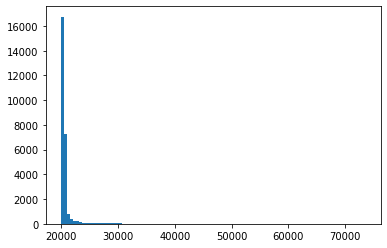

In [10]:
import matplotlib.pyplot as plt
plt.hist(items_mapping['model_count'],100);

In [11]:
np.max(items_mapping['id'])

26744

In [12]:
np.sum(items_mapping['model_count'])

556301394

In [13]:
np.sum(users_mapping['model_count'])

556301394

In [14]:
class flag(object):
    def __init__(self):
        
        # Model configuration
        self.embedding_type = "joint" # The type of the embedding operation to use")
        self.embedding_dim = 64 # "Dimensionality of embedding space for categorical features")
        self.top_mlp_sizes = [64, 1] # "Linear layer sizes for the top MLP")
        self.bottom_mlp_sizes = [128, 64] #Linear layer sizes for the bottom MLP")

        self.interaction_op ="cuda_dot" #"Type of interaction operation to perform.")

        self.dataset = "/data/dlrm/binary_dataset/"
        self.dataset_type = "split" #The type of the dataset to use')

        self.base_device = "cuda" #"Device to run the majority of the model operations")
        self.amp = False #If True the script will use Automatic Mixed Precision")
        self.optimized_mlp = True #Use an optimized implementation of MLP from apex")
        self.max_table_size = None #Maximum number of rows per embedding table, by default equal to the number of unique values for each categorical variable")
        self.num_numerical_features = 1
        self.hash_indices = False

In [15]:
FLAGS = flag()

print("Creating model")

model_config = {
    'top_mlp_sizes': FLAGS.top_mlp_sizes,
    'bottom_mlp_sizes': FLAGS.bottom_mlp_sizes,
    'embedding_type': FLAGS.embedding_type,
    'embedding_dim': FLAGS.embedding_dim,
    'interaction_op': FLAGS.interaction_op,
    'categorical_feature_sizes': get_categorical_feature_sizes(FLAGS),
    'num_numerical_features': FLAGS.num_numerical_features,
    'hash_indices': FLAGS.hash_indices,
    'use_cpp_mlp': FLAGS.optimized_mlp,
    'fp16': FLAGS.amp,
    'base_device': FLAGS.base_device,
}

model = Dlrm.from_dict(model_config)
print(model)

Creating model
feature sizes:  [138494, 26745]
Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 138494 165239]
      (embedding): Embedding(165239, 64)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [1, 128, 64], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [68, 64], Bias=1, activation=1)
    )
    (out): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [16]:
checkpoint_loader = make_serial_checkpoint_loader(
            embedding_indices=range(len(get_categorical_feature_sizes(FLAGS))),
            device="cpu"
        )
checkpoint_loader.load_checkpoint(model, "/workspace/dlrm_vinhn/notebooks/movie_lens_model-smallnet")
model.eval()
model.to(FLAGS.base_device)

feature sizes:  [138494, 26745]


/workspace/dlrm/dlrm/utils/checkpointing/model.py:128: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(array).to(self._device)


Dlrm(
  interaction_op=cuda_dot, hash_indices=False
  (bottom_model): DlrmBottom(
    (embeddings): JointEmbedding(
      offsets=[     0 138494 165239]
      (embedding): Embedding(165239, 64)
    )
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [1, 128, 64], Bias=1, activation=1)
    )
  )
  (top_model): DlrmTop(
    (mlp): CppMlp(
      (mlp): MLP(MLP sizes: [68, 64], Bias=1, activation=1)
    )
    (out): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [17]:
model.bottom_model.embeddings.embedding.weight.shape

torch.Size([165239, 64])

In [18]:
embedding = model.bottom_model.embeddings.embedding.weight.detach().cpu().numpy()

In [19]:
item_embedding = embedding[138494:]
item_embedding.shape

(26745, 64)

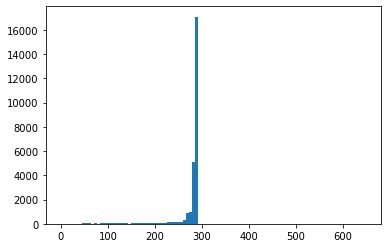

In [20]:
plt.hist(np.linalg.norm(item_embedding, axis=1),100);

In [21]:
from scipy.spatial.distance import cdist
def find_similar_movies(nn_movie_id, item_embedding, k=10, metric='cosine'):
    sim = -cdist(item_embedding, item_embedding[nn_movie_id].reshape(1, -1), metric=metric)
    #sim = np.matmul(item_embedding, item_embedding[nn_movie_id].transpose())
    return sim.squeeze().argsort()[-k:][::-1]

In [22]:
nn_to_movies = {}
movies_to_nn = {}
for _, row in items_mapping.iterrows():
    movies_to_nn[int(row['data'])] = int(row['id'])
    nn_to_movies[int(row['id'])] = int(row['data'])


In [23]:
import pandas as pd
movies = pd.read_csv("/mnt/dldata/vinhn/DeepLearningExamples/PyTorch/Recommendation/NCF/data/ml-20m/movies.csv", index_col="movieId")

movie_ID = 1196 
print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

print("Similar movies: ")
similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)

for i in similar_movies:
    if i==0:
        continue
    print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])

Query:  Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
Similar movies: 
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
1210 Star Wars: Episode VI - Return of the Jedi (1983) Action|Adventure|Sci-Fi
2858 American Beauty (1999) Comedy|Drama
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
858 Godfather, The (1972) Crime|Drama
1198 Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) Action|Adventure
367 Mask, The (1994) Action|Comedy|Crime|Fantasy
1136 Monty Python and the Holy Grail (1975) Adventure|Comedy|Fantasy
1721 Titanic (1997) Drama|Romance
2028 Saving Private Ryan (1998) Action|Drama|War


In [24]:
for movie_ID in range(1000):
    try:
        print("Query: ", movies.loc[movie_ID]["title"], movies.loc[movie_ID]["genres"])

        print("Similar movies: ")
        similar_movies = find_similar_movies(movies_to_nn[movie_ID], item_embedding)

        for i in similar_movies:
            if i==0:
                continue
            print(nn_to_movies[i], movies.loc[nn_to_movies[i]]["title"], movies.loc[nn_to_movies[i]]["genres"])
        print('===============\n')
    except Exception as e:
        print(e)
        pass

0
Query:  Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
Similar movies: 
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
527 Schindler's List (1993) Drama|War
608 Fargo (1996) Comedy|Crime|Drama|Thriller
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
110 Braveheart (1995) Action|Drama|War
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
590 Dances with Wolves (1990) Adventure|Drama|Western
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical

Query:  Jumanji (1995) Adventure|Children|Fantasy
Similar movies: 
2 Jumanji (1995) Adventure|Children|Fantasy
223 Clerks (1994) Comedy
586 Home Alone (1990) Children|Comedy
357 Four Weddings and a Funeral (1994) Comedy|Romance
539 Sleepless in Seattle (1993) Comedy|Drama|Romance
2396 Shakespeare in Love (1998) Comedy|Drama|Romance
39 Clueless (1995) Comedy|Roman

Similar movies: 
17 Sense and Sensibility (1995) Drama|Romance
141 Birdcage, The (1996) Comedy
36 Dead Man Walking (1995) Crime|Drama
95 Broken Arrow (1996) Action|Adventure|Thriller
25 Leaving Las Vegas (1995) Drama|Romance
62 Mr. Holland's Opus (1995) Drama
329 Star Trek: Generations (1994) Adventure|Drama|Sci-Fi
21 Get Shorty (1995) Comedy|Crime|Thriller
11 American President, The (1995) Comedy|Drama|Romance
339 While You Were Sleeping (1995) Comedy|Romance

Query:  Four Rooms (1995) Comedy
Similar movies: 
18 Four Rooms (1995) Comedy
8865 Sky Captain and the World of Tomorrow (2004) Action|Adventure|Sci-Fi
37386 Aeon Flux (2005) Action|Sci-Fi
49910 Freedom Writers (2007) Drama
94780 Snow White and the Huntsman (2012) Action|Adventure|Drama
106107 Order and Disorder (2009) Documentary
94833 Pirates! Band of Misfits, The (2012) Adventure|Animation|Children|Comedy
101529 Brass Teapot, The (2012) Comedy|Fantasy|Thriller
94325 Lucky One, The (2012) Drama
6844 Oleanna (1994) Drama

Query

253 Interview with the Vampire: The Vampire Chronicles (1994) Drama|Horror
595 Beauty and the Beast (1991) Animation|Children|Fantasy|Musical|Romance|IMAX
6 Heat (1995) Action|Crime|Thriller
1073 Willy Wonka & the Chocolate Factory (1971) Children|Comedy|Fantasy|Musical

Query:  Carrington (1995) Drama|Romance
Similar movies: 
35 Carrington (1995) Drama|Romance
3677 Baraka (1992) Documentary
2119 Maximum Overdrive (1986) Horror
2560 Ravenous (1999) Horror|Thriller
1006 Chamber, The (1996) Drama
4748 3 Ninjas (1992) Action|Children|Comedy
270 Love Affair (1994) Drama|Romance
1007 Apple Dumpling Gang, The (1975) Children|Comedy|Western
7007 Last Boy Scout, The (1991) Action|Comedy|Crime|Drama|Thriller
3548 Auntie Mame (1958) Comedy|Drama

Query:  Dead Man Walking (1995) Crime|Drama
Similar movies: 
36 Dead Man Walking (1995) Crime|Drama
329 Star Trek: Generations (1994) Adventure|Drama|Sci-Fi
25 Leaving Las Vegas (1995) Drama|Romance
95 Broken Arrow (1996) Action|Adventure|Thriller
349 C

53 Lamerica (1994) Adventure|Drama
129307 Wu yen (2001) Comedy|Fantasy
108016 Resistance (2011) Drama|Thriller|War
87055 Tomorrow We Move (Demain on déménage) (2004) Comedy
94955 Harriet Craig (1950) Drama
116307 You're Not You (2014) Drama
101592 Bird of the Air, A (Loop, The) (2011) Drama|Romance
35618 Third Wheel, The (2002) Comedy|Romance
6540 Madame Satã (2002) Drama
89870 Clapham Junction (2007) Drama

Query:  Big Green, The (1995) Children|Comedy
Similar movies: 
54 Big Green, The (1995) Children|Comedy
7841 Children of Dune (2003) Fantasy|Sci-Fi
47640 Beerfest (2006) Comedy
61248 Death Race (2008) Action|Adventure|Sci-Fi|Thriller
4644 Bread and Tulips (Pane e tulipani) (2000) Comedy|Drama|Romance
6558 Curly Sue (1991) Comedy|Drama
6695 Jeepers Creepers 2 (2003) Horror|Thriller
2330 Hands on a Hard Body (1996) Comedy|Documentary
2095 Shaggy D.A., The (1976) Children|Comedy
5792 Roger Dodger (2002) Comedy|Drama

Query:  Georgia (1995) Drama
Similar movies: 
55 Georgia (1995) Dram

3824 Autumn in New York (2000) Drama|Romance
1361 Paradise Lost: The Child Murders at Robin Hood Hills (1996) Documentary

Query:  Kicking and Screaming (1995) Comedy|Drama
Similar movies: 
72 Kicking and Screaming (1995) Comedy|Drama
4733 Curse of the Jade Scorpion, The (2001) Comedy
944 Lost Horizon (1937) Drama
3871 Shane (1953) Drama|Western
7155 Calendar Girls (2003) Comedy
6810 Sleeping with the Enemy (1991) Drama|Thriller
1821 Object of My Affection, The (1998) Comedy|Romance
5008 Witness for the Prosecution (1957) Drama|Mystery|Thriller
437 Cops and Robbersons (1994) Comedy
892 Twelfth Night (1996) Comedy|Drama|Romance

Query:  Misérables, Les (1995) Drama|War
Similar movies: 
73 Misérables, Les (1995) Drama|War
55768 Bee Movie (2007) Animation|Comedy
5804 Santa Clause 2, The (2002) Children|Comedy|Fantasy|Romance
2514 Pet Sematary II (1992) Comedy|Horror
4613 K-9 (1989) Action|Comedy|Crime
3287 Tigger Movie, The (2000) Animation|Children
2446 In Dreams (1999) Horror|Thriller
1

90 Journey of August King, The (1995) Drama
117496 Alien Nation: Millennium (1996) Sci-Fi
45527 Standing Still (2005) Comedy|Drama|Romance
78276 Hail Mary ('Je vous salue, Marie') (1985) Drama
112003 Thompsons, The (2012) Drama|Horror|Thriller
115821 Shakespeare's Globe: Henry V (2013) Drama
130614 Goodbye Uncle Tom (1971) Drama
98615 Burn Up! (1991) Action|Animation
97690 Sunday in Kigali, A (Un dimanche à Kigali) (2006) Drama|War
110196 i hate myself :) (2013) Comedy|Documentary|Drama

91
Query:  Mary Reilly (1996) Drama|Horror|Thriller
Similar movies: 
92 Mary Reilly (1996) Drama|Horror|Thriller
7649 Babylon 5: In the Beginning (1998) Adventure|Sci-Fi
3347 Never Cry Wolf (1983) Adventure|Drama
27821 Interpreter, The (2005) Drama|Thriller
2249 My Blue Heaven (1990) Comedy
2787 Cat's Eye (1985) Horror
4936 Fame (1980) Drama|Musical
2240 My Bodyguard (1980) Drama
8507 Freaks (1932) Crime|Drama|Horror
2038 Cat from Outer Space, The (1978) Children|Comedy|Sci-Fi

Query:  Vampire in Brook

105388 Prison of the Dead (2000) Horror
113707 Kummeli V (2014) Comedy
123645 A Lesson Before Dying (1999) Drama

Query:  Braveheart (1995) Action|Drama|War
Similar movies: 
110 Braveheart (1995) Action|Drama|War
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
590 Dances with Wolves (1990) Adventure|Drama|Western
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
527 Schindler's List (1993) Drama|War
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
10 GoldenEye (1995) Action|Adventure|Thriller
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
608 Fargo (1996) Comedy|Crime|Drama|Thriller

Query:  Taxi Driver (1976) Crime|Drama|Thriller
Similar movies: 
111 Taxi Driver (1976) Crime|Drama|Thriller
377 Speed (1994) Action|Romance|Thriller
293 Léon: The Professional (a.k.a. The Professional) (Léon) (1994) Action|Crime|Drama|Thriller
364 Lion King, The (1994) Adventure|Animation|Children|Dra

128 Jupiter's Wife (1994) Documentary
32935 Evil Remains (Trespassing) (2004) Horror|Thriller
32497 Love Letter (1995)  Drama|Romance
100147 Act in Question, The (Acto en cuestión, El) (1993) Drama
106972 Man You Had in Mind, The (2006) Documentary
74547 Darling Lili (1970) Drama|War
31645 Reap the Wild Wind (1942) Action|Adventure|Drama
4859 Kansas (1988) Crime|Drama
108005 Flesh Merchant, The (Wild and Wicked, The) (1956) Drama
79496 Restless (Uro) (2006) Action|Crime|Thriller

Query:  Pie in the Sky (1996) Comedy|Romance
Similar movies: 
129 Pie in the Sky (1996) Comedy|Romance
91888 Chico & Rita (2010) Animation|Musical|Romance
6912 You'll Never Get Rich (1941) Comedy|Musical|Romance
103633 Making a Killing: The Untold Story of Psychotropic Drugging (2008) Documentary
108316 American Scary (2006) Comedy|Documentary|Horror
109102 Little Brother, Big Trouble: A Christmas Adventure (Niko 2: Lentäjäveljekset) (2012) Adventure|Animation|Children|Comedy
43624 Here Comes the Groom (1951) 

86377 Louis C.K.: Shameless (2007) Comedy
325 National Lampoon's Senior Trip (1995) Comedy
2084 Newsies (1992) Children|Musical
81537 Due Date (2010) Comedy
3350 Raisin in the Sun, A (1961) Drama
187 Party Girl (1995) Comedy
43836 Pink Panther, The (2006) Adventure|Comedy|Crime

Query:  Awfully Big Adventure, An (1995) Drama
Similar movies: 
148 Awfully Big Adventure, An (1995) Drama
52202 His Kind of Woman (1951) Comedy|Crime|Drama|Film-Noir|Thriller
123571 Jim Jefferies: Alcoholocaust (2010) Comedy
114760 Happy Christmas (2014) Comedy|Drama
112301 Tall Story (1960) Comedy
112599 Favor (2013) Thriller
8688 Shalako (1968) Western
83248 This Night I'll Possess Your Corpse (Esta Noite Encarnarei no Teu Cadáver) (1967) Horror
90021 I'm Gonna Explode (a.k.a. I'm Going to Explode) (Voy a explotar) (2008) Drama
60145 Penalty, The (1920) Crime|Drama|Horror

Query:  Amateur (1994) Crime|Drama|Thriller
Similar movies: 
149 Amateur (1994) Crime|Drama|Thriller
47423 Half Nelson (2006) Drama
10304

61414 Tobacco Road (1941) Comedy|Drama
106527 Chocchan's Story (Chocchan monogatari) (1996) Animation|Drama|War

Query:  Feast of July (1995) Drama
Similar movies: 
167 Feast of July (1995) Drama
98783 Shaolin Temple 3: Martial Arts of Shaolin (Nan bei Shao Lin) (Martial Arts of Shaolin) (1986) Action
92600 As Luck Would Have It (Chispa de la vida, La) (2011) Drama
61707 Ladrón que roba a ladrón (2007) Action|Adventure|Comedy|Crime
129719 That's Life (1998) Comedy
6007 P.S. Your Cat is Dead (2002) Comedy
111740 Ordinary Miracles (2005) Drama
83756 Facing the Truth (At kende sandheden) (2002) Drama
97137 Cool Ones, The (1967) Comedy
125976 Nocturna Artificialia (1979) Animation

Query:  First Knight (1995) Action|Drama|Romance
Similar movies: 
168 First Knight (1995) Action|Drama|Romance
315 Specialist, The (1994) Action|Drama|Thriller
186 Nine Months (1995) Comedy|Romance
282 Nell (1994) Drama
52 Mighty Aphrodite (1995) Comedy|Drama|Romance
252 I.Q. (1994) Comedy|Romance
256 Junior (19

185 Net, The (1995) Action|Crime|Thriller
454 Firm, The (1993) Drama|Thriller
161 Crimson Tide (1995) Drama|Thriller|War
434 Cliffhanger (1993) Action|Adventure|Thriller
165 Die Hard: With a Vengeance (1995) Action|Crime|Thriller
253 Interview with the Vampire: The Vampire Chronicles (1994) Drama|Horror
316 Stargate (1994) Action|Adventure|Sci-Fi
349 Clear and Present Danger (1994) Action|Crime|Drama|Thriller
595 Beauty and the Beast (1991) Animation|Children|Fantasy|Musical|Romance|IMAX
208 Waterworld (1995) Action|Adventure|Sci-Fi

Query:  Nine Months (1995) Comedy|Romance
Similar movies: 
186 Nine Months (1995) Comedy|Romance
282 Nell (1994) Drama
315 Specialist, The (1994) Action|Drama|Thriller
252 I.Q. (1994) Comedy|Romance
168 First Knight (1995) Action|Drama|Romance
52 Mighty Aphrodite (1995) Comedy|Drama|Romance
256 Junior (1994) Comedy|Sci-Fi
261 Little Women (1994) Drama
105 Bridges of Madison County, The (1995) Drama|Romance
783 Hunchback of Notre Dame, The (1996) Animation|

3916 Remember the Titans (2000) Drama
610 Heavy Metal (1981) Action|Adventure|Animation|Horror|Sci-Fi
2722 Deep Blue Sea (1999) Action|Horror|Sci-Fi|Thriller
524 Rudy (1993) Drama
3148 Cider House Rules, The (1999) Drama
29 City of Lost Children, The (Cité des enfants perdus, La) (1995) Adventure|Drama|Fantasy|Mystery|Sci-Fi

Query:  Unstrung Heroes (1995) Comedy|Drama
Similar movies: 
205 Unstrung Heroes (1995) Comedy|Drama
109487 Interstellar (2014) Sci-Fi|IMAX
82461 Tron: Legacy (2010) Action|Adventure|Sci-Fi|IMAX
8973 Bad Education (La mala educación) (2004) Drama|Thriller
4533 Return of the Living Dead, The (1985) Comedy|Horror|Sci-Fi
55363 Assassination of Jesse James by the Coward Robert Ford, The (2007) Crime|Drama|Western
1503 8 Heads in a Duffel Bag (1997) Comedy
1999 Exorcist III, The (1990) Horror
2453 Boy Who Could Fly, The (1986) Drama|Fantasy
1382 Marked for Death (1990) Action|Drama

Query:  Unzipped (1995) Documentary
Similar movies: 
206 Unzipped (1995) Documentary
85

272 Madness of King George, The (1994) Comedy|Drama
616 Aristocats, The (1970) Animation|Children
306 Three Colors: Red (Trois couleurs: Rouge) (1994) Drama
2826 13th Warrior, The (1999) Action|Adventure|Fantasy
348 Bullets Over Broadway (1994) Comedy
8376 Napoleon Dynamite (2004) Comedy
800 Lone Star (1996) Drama|Mystery|Western

Query:  Disclosure (1994) Drama|Thriller
Similar movies: 
225 Disclosure (1994) Drama|Thriller
432 City Slickers II: The Legend of Curly's Gold (1994) Adventure|Comedy|Western
7 Sabrina (1995) Comedy|Romance
151 Rob Roy (1995) Action|Drama|Romance|War
236 French Kiss (1995) Action|Comedy|Romance
282 Nell (1994) Drama
435 Coneheads (1993) Comedy|Sci-Fi
315 Specialist, The (1994) Action|Drama|Thriller
168 First Knight (1995) Action|Drama|Romance
494 Executive Decision (1996) Action|Adventure|Thriller

Query:  Dream Man (1995) Thriller
Similar movies: 
226 Dream Man (1995) Thriller
41596 Where Were You When the Lights Went Out? (1968) Comedy
126593 Kocken (2005)

33480 Babes in Arms (1939) Comedy|Musical
111852 Generation Iron (2013) Documentary

Query:  Gumby: The Movie (1995) Animation|Children
Similar movies: 
244 Gumby: The Movie (1995) Animation|Children
129905 The Floating Castle (2012) Comedy|Drama
99615 Role/Play (2010) Drama
60475 Violin, El (2005) Drama
104041 Arrival II (1998) Action|Adventure|Sci-Fi
80759 Hardcore (2004) Crime|Drama
116207 Zulu (2013) Crime|Drama|Thriller
88975 Where Are the Dreams of Youth? (Seishun no yume imaizuko) (1932) Drama
128968 Stitch! The Movie (2003) Animation|Children|Comedy
96734 John Huston: The Man, the Movies, the Maverick (1989) Documentary

Query:  Glass Shield, The (1994) Crime|Drama
Similar movies: 
245 Glass Shield, The (1994) Crime|Drama
90566 Cab for Three, A (Taxi para tres) (2001) Action|Comedy|Crime|Drama
82246 Human Experience, The (2008) Documentary
97694 Barrens, The (2012) Horror
82139 Not Forgotten (2009) Thriller
116791 Callan (1974) Thriller
84500 Seventh Horse of the Sun  (Suraj Ka

4063 Prelude to a Kiss (1992) Comedy|Drama|Romance
86548 Water for Elephants (2011) Drama|Romance
6340 Only the Strong Survive - A Celebration of Soul (2002) Documentary|Musical
5843 Toy Soldiers (1991) Action|Drama
2818 Iron Eagle IV (1995) Action|War

Query:  Ladybird Ladybird (1994) Drama
Similar movies: 
263 Ladybird Ladybird (1994) Drama
4933 Earthling, The (1980) Adventure|Drama
72678 Région centrale, La (1971) Drama
109434 Psychosis (2010) Crime|Horror|Mystery
127066 Art and Craft (2014) Documentary
45689 Bleak Moments (1972) Comedy|Drama
90011 Wrestling (Bræðrabylta) (2007) Drama|Romance
103794 Middle of the World, The (O Caminho das Nuvens) (2003) Drama
115439 10 minutes (10 minuta) (2002) Drama|War
60494 Borderline (1950) Crime|Drama|Romance

Query:  Enfer, L' (1994) Drama
Similar movies: 
264 Enfer, L' (1994) Drama
106870 Grave Encounters 2 (2012) Horror
109183 Date and Switch (2014) Comedy
7765 Perfectly Normal (1990) Comedy
109034 Evidence (1995) Documentary
60341 Standard


Query:  Nell (1994) Drama
Similar movies: 
282 Nell (1994) Drama
315 Specialist, The (1994) Action|Drama|Thriller
186 Nine Months (1995) Comedy|Romance
252 I.Q. (1994) Comedy|Romance
52 Mighty Aphrodite (1995) Comedy|Drama|Romance
168 First Knight (1995) Action|Drama|Romance
256 Junior (1994) Comedy|Sci-Fi
265 Like Water for Chocolate (Como agua para chocolate) (1992) Drama|Fantasy|Romance
236 French Kiss (1995) Action|Comedy|Romance
58 Postman, The (Postino, Il) (1994) Comedy|Drama|Romance

Query:  New Jersey Drive (1995) Crime|Drama
Similar movies: 
283 New Jersey Drive (1995) Crime|Drama
8240 Totally F***ed Up (1993) Drama
120879 Soap and Water (1983) Comedy
126122 Let's Get Those English Girls (1976) Comedy
77744 3rd Voice, The (1960) Crime|Drama|Thriller
100421 Dancing in the Rain (Ples v dezju) (1961) Drama
79228 Like Minds (Murderous Intent) (2006) Crime|Mystery|Thriller
884 Sweet Nothing (1996) Drama
7413 Hangman's Curse (2003) Horror|Mystery|Thriller
84734 Old Man Made in Spa

300 Quiz Show (1994) Drama
161 Crimson Tide (1995) Drama|Thriller|War
434 Cliffhanger (1993) Action|Adventure|Thriller
185 Net, The (1995) Action|Crime|Thriller
454 Firm, The (1993) Drama|Thriller
349 Clear and Present Danger (1994) Action|Crime|Drama|Thriller
329 Star Trek: Generations (1994) Adventure|Drama|Sci-Fi
339 While You Were Sleeping (1995) Comedy|Romance
253 Interview with the Vampire: The Vampire Chronicles (1994) Drama|Horror
95 Broken Arrow (1996) Action|Adventure|Thriller

Query:  Picture Bride (Bijo photo) (1994) Drama|Romance
Similar movies: 
301 Picture Bride (Bijo photo) (1994) Drama|Romance
102753 Past, The (Le passé) (2013) Drama|Mystery|Romance
44241 Leprechaun 3 (1995) Comedy|Fantasy|Horror
39419 Where the Truth Lies (2005) Drama|Thriller
4695 Who'll Stop the Rain (1978) Crime|Drama
59888 Boat People (Tau ban no hoi) (1982) Drama
108520 Louise Bourgeois: The Spider, the Mistress and the Tangerine (2008) Documentary
2226 Ring, The (1927) Drama
44020 Ultimate Aveng

457 Fugitive, The (1993) Thriller

Query:  Shallow Grave (1994) Comedy|Drama|Thriller
Similar movies: 
319 Shallow Grave (1994) Comedy|Drama|Thriller
1269 Arsenic and Old Lace (1944) Comedy|Mystery|Thriller
30793 Charlie and the Chocolate Factory (2005) Adventure|Children|Comedy|Fantasy|IMAX
1960 Last Emperor, The (1987) Drama
3148 Cider House Rules, The (1999) Drama
3072 Moonstruck (1987) Comedy|Romance
610 Heavy Metal (1981) Action|Adventure|Animation|Horror|Sci-Fi
1717 Scream 2 (1997) Comedy|Horror|Mystery|Thriller
3361 Bull Durham (1988) Comedy|Drama|Romance
1188 Strictly Ballroom (1992) Comedy|Romance

Query:  Suture (1993) Film-Noir|Thriller
Similar movies: 
320 Suture (1993) Film-Noir|Thriller
72607 Portraits of Women (Naisenkuvia) (1970) Comedy|Drama
94750 My Blue Heaven (1950) Drama|Musical
55751 Decoys (2004) Comedy|Horror|Sci-Fi
77296 Normal Adolescent Behavior (2007) Drama|Romance
112261 I See a Dark Stranger (1946) Romance|Thriller
32627 Rhinestone (1984) Comedy
59867 Lone

338 Virtuosity (1995) Action|Sci-Fi|Thriller
4077 With a Friend Like Harry... (Harry, un ami qui vous veut du bien) (2000) Drama|Thriller
5680 Auto Focus (2002) Crime|Drama
8643 Cinderella Story, A (2004) Comedy|Romance
5792 Roger Dodger (2002) Comedy|Drama
2330 Hands on a Hard Body (1996) Comedy|Documentary
6852 In Cold Blood (1967) Crime|Drama
2280 Clay Pigeons (1998) Crime
104374 About Time (2013) Drama|Fantasy|Romance
56715 Wristcutters: A Love Story (2006) Drama|Fantasy|Romance

Query:  While You Were Sleeping (1995) Comedy|Romance
Similar movies: 
339 While You Were Sleeping (1995) Comedy|Romance
329 Star Trek: Generations (1994) Adventure|Drama|Sci-Fi
349 Clear and Present Danger (1994) Action|Crime|Drama|Thriller
454 Firm, The (1993) Drama|Thriller
161 Crimson Tide (1995) Drama|Thriller|War
434 Cliffhanger (1993) Action|Adventure|Thriller
95 Broken Arrow (1996) Action|Adventure|Thriller
25 Leaving Las Vegas (1995) Drama|Romance
185 Net, The (1995) Action|Crime|Thriller
36 Dead 

357 Four Weddings and a Funeral (1994) Comedy|Romance
39 Clueless (1995) Comedy|Romance
34 Babe (1995) Children|Drama
539 Sleepless in Seattle (1993) Comedy|Drama|Romance
6 Heat (1995) Action|Crime|Thriller
736 Twister (1996) Action|Adventure|Romance|Thriller
316 Stargate (1994) Action|Adventure|Sci-Fi
1073 Willy Wonka & the Chocolate Factory (1971) Children|Comedy|Fantasy|Musical
595 Beauty and the Beast (1991) Animation|Children|Fantasy|Musical|Romance|IMAX
253 Interview with the Vampire: The Vampire Chronicles (1994) Drama|Horror

Query:  Higher Learning (1995) Drama
Similar movies: 
358 Higher Learning (1995) Drama
53956 Death at a Funeral (2007) Comedy
917 Little Princess, The (1939) Children|Drama
88810 Help, The (2011) Drama
2195 Dirty Work (1998) Comedy
4846 Iron Monkey (Siu nin Wong Fei-hung ji: Tit Ma Lau) (1993) Action|Comedy
6666 Discreet Charm of the Bourgeoisie, The (Charme discret de la bourgeoisie, Le) (1972) Comedy|Drama|Fantasy
7000 Hudson Hawk (1991) Action|Adventure

376 River Wild, The (1994) Action|Thriller
52 Mighty Aphrodite (1995) Comedy|Drama|Romance
261 Little Women (1994) Drama
256 Junior (1994) Comedy|Sci-Fi
265 Like Water for Chocolate (Como agua para chocolate) (1992) Drama|Fantasy|Romance
105 Bridges of Madison County, The (1995) Drama|Romance
252 I.Q. (1994) Comedy|Romance
661 James and the Giant Peach (1996) Adventure|Animation|Children|Fantasy|Musical
348 Bullets Over Broadway (1994) Comedy
246 Hoop Dreams (1994) Documentary

Query:  Speed (1994) Action|Romance|Thriller
Similar movies: 
377 Speed (1994) Action|Romance|Thriller
648 Mission: Impossible (1996) Action|Adventure|Mystery|Thriller
364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance
541 Blade Runner (1982) Action|Sci-Fi|Thriller
1213 Goodfellas (1990) Crime|Drama
111 Taxi Driver (1976) Crime|Drama|Thriller
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
2571 Mat

Similar movies: 
396 Fall Time (1995) Drama
107316 WW III: World War III (Der 3. Weltkrieg) (1998) Documentary|War
91335 Gruffalo, The (2009) Adventure|Animation|Children|Comedy|Drama
88374 Arrangement, The (1969) Drama
80725 Squaw Man, The (1914) Drama|Western
86829 Macbeth (1982) Drama
32653 This Land Is Mine (1943) Drama|War
41025 Good Woman, A (2004) Comedy|Drama|Romance
96084 Hands Over the City (Le mani sulla città) (1963) Drama
99335 Addicted (2013) Drama

Query:  Fear, The (1995) Horror
Similar movies: 
397 Fear, The (1995) Horror
69722 Dirt Bike Kid, The (1985) Children|Comedy|Fantasy
83339 Main Prem Ki Diwani Hoon (2003) Comedy|Drama|Romance
102969 Era of Vampires, The (2003) Action|Horror
96292 Immensee (1943) Drama
7204 Hells Angels on Wheels (1967) Drama
92186 Three Wise Men (Kolme viisasta miestä) (2008) Drama
26302 Scarecrow (1973) Drama
109665 Messages Deleted (2010) Mystery|Thriller
5281 Wrong Guys, The (1988) Comedy

Query:  Frank and Ollie (1995) Documentary
Similar 

117450 Exit (2011) Drama
116823 The Hunger Games: Mockingjay - Part 1 (2014) Adventure|Sci-Fi|Thriller

Query:  Another Stakeout (1993) Comedy|Thriller
Similar movies: 
415 Another Stakeout (1993) Comedy|Thriller
83134 Tucker & Dale vs Evil (2010) Comedy|Horror
5414 Bad Company (2002) Action|Comedy|Crime
3045 Peter's Friends (1992) Comedy|Drama
46948 Monster House (2006) Animation|Children|Fantasy|Mystery
71211 Informant!, The (2009) Comedy|Crime|Drama|Thriller
1162 Ruling Class, The (1972) Comedy|Drama
4915 Beastmaster, The (1982) Action|Adventure|Fantasy
44788 This Film Is Not Yet Rated (2006) Documentary
40 Cry, the Beloved Country (1995) Drama

Query:  Bad Girls (1994) Western
Similar movies: 
416 Bad Girls (1994) Western
725 Great White Hype, The (1996) Comedy
946 To Be or Not to Be (1942) Comedy|Drama|War
948 Giant (1956) Drama|Romance|Western
352 Crooklyn (1994) Comedy|Drama
1972 Nightmare on Elm Street 5: The Dream Child, A (1989) Horror
2504 200 Cigarettes (1999) Comedy|Drama


3125 End of the Affair, The (1999) Drama
6338 Daddy Day Care (2003) Children|Comedy

Query:  Cliffhanger (1993) Action|Adventure|Thriller
Similar movies: 
434 Cliffhanger (1993) Action|Adventure|Thriller
454 Firm, The (1993) Drama|Thriller
185 Net, The (1995) Action|Crime|Thriller
349 Clear and Present Danger (1994) Action|Crime|Drama|Thriller
165 Die Hard: With a Vengeance (1995) Action|Crime|Thriller
161 Crimson Tide (1995) Drama|Thriller|War
316 Stargate (1994) Action|Adventure|Sci-Fi
253 Interview with the Vampire: The Vampire Chronicles (1994) Drama|Horror
595 Beauty and the Beast (1991) Animation|Children|Fantasy|Musical|Romance|IMAX
329 Star Trek: Generations (1994) Adventure|Drama|Sci-Fi

Query:  Coneheads (1993) Comedy|Sci-Fi
Similar movies: 
435 Coneheads (1993) Comedy|Sci-Fi
432 City Slickers II: The Legend of Curly's Gold (1994) Adventure|Comedy|Western
225 Disclosure (1994) Drama|Thriller
7 Sabrina (1995) Comedy|Romance
172 Johnny Mnemonic (1995) Action|Sci-Fi|Thriller
151

Query:  For Love or Money (1993) Comedy|Romance
Similar movies: 
453 For Love or Money (1993) Comedy|Romance
2418 Nothing in Common (1986) Comedy
4803 Play Misty for Me (1971) Drama|Thriller
5269 Piano Teacher, The (La pianiste) (2001) Drama
4686 Weekend at Bernie's II (1993) Adventure|Comedy
325 National Lampoon's Senior Trip (1995) Comedy
2170 Wrongfully Accused (1998) Action|Comedy
94777 Men in Black III (M.III.B.) (M.I.B.³) (2012) Action|Comedy|Sci-Fi|IMAX
6650 Kind Hearts and Coronets (1949) Comedy|Drama
1646 RocketMan (a.k.a. Rocket Man) (1997) Children|Comedy|Romance|Sci-Fi

Query:  Firm, The (1993) Drama|Thriller
Similar movies: 
454 Firm, The (1993) Drama|Thriller
349 Clear and Present Danger (1994) Action|Crime|Drama|Thriller
434 Cliffhanger (1993) Action|Adventure|Thriller
185 Net, The (1995) Action|Crime|Thriller
329 Star Trek: Generations (1994) Adventure|Drama|Sci-Fi
161 Crimson Tide (1995) Drama|Thriller|War
165 Die Hard: With a Vengeance (1995) Action|Crime|Thriller
595

472 I'll Do Anything (1994) Comedy|Drama
90609 Camouflage (Barwy ochronne) (1977) Comedy|Drama
128316 The Tree, the Mayor and the Mediatheque (1993) Comedy
68482 XIII: The Conspiracy (2008) Action|Crime|Mystery|Thriller
103190 Oblivion Island: Haruka and the Magic Mirror (Hottarake no shima - Haruka to maho no kagami) (2009) Adventure|Animation|Fantasy
112446 Escape Artist, The (2013) Drama|Thriller
118574 Chantilly Lace (1993) Drama
6009 City of Lost Souls, The (Hyôryuu-gai) (2000) Crime|Drama|Thriller
72906 Not Reconciled (Nicht versöhnt oder Es hilft nur Gewalt wo Gewalt herrscht) (1965) Drama
111776 Violent Men, The (1955) Western

Query:  In the Army Now (1994) Comedy|War
Similar movies: 
473 In the Army Now (1994) Comedy|War
946 To Be or Not to Be (1942) Comedy|Drama|War
4757 Rock Star (2001) Comedy|Drama|Musical
60037 Happening, The (2008) Drama|Sci-Fi|Thriller
3727 Near Dark (1987) Horror|Western
5016 Shipping News, The (2001) Drama
5047 Kung Pow: Enter the Fist (2002) Action|C

Similar movies: 
491 Man Without a Face, The (1993) Drama
83132 Secret World of Arrietty, The (Kari-gurashi no Arietti) (2010) Animation|Children|Fantasy
52287 Meet the Robinsons (2007) Action|Adventure|Animation|Children|Comedy|Sci-Fi
2419 Extremities (1986) Drama|Thriller
2451 Gate, The (1987) Horror
4063 Prelude to a Kiss (1992) Comedy|Drama|Romance
82840 Home Song Stories, The (2007) Drama
34520 Dukes of Hazzard, The (2005) Action|Adventure|Comedy
27838 Mean Creek (2004) Drama|Thriller
123761 The Golden Eye (1948) Crime|Mystery|Thriller

Query:  Manhattan Murder Mystery (1993) Comedy|Mystery
Similar movies: 
492 Manhattan Murder Mystery (1993) Comedy|Mystery
2446 In Dreams (1999) Horror|Thriller
1162 Ruling Class, The (1972) Comedy|Drama
4020 Gift, The (2000) Thriller
44788 This Film Is Not Yet Rated (2006) Documentary
41863 Three Burials of Melquiades Estrada, The (2006) Adventure|Crime|Drama
2272 One True Thing (1998) Drama
89753 Tinker Tailor Soldier Spy (2011) Drama|Film-Noir|T

510 Poetic Justice (1993) Drama
7841 Children of Dune (2003) Fantasy|Sci-Fi
5680 Auto Focus (2002) Crime|Drama
56333 Savages, The (2007) Comedy|Drama
81537 Due Date (2010) Comedy
5792 Roger Dodger (2002) Comedy|Drama
52241 Lookout, The (2007) Crime|Drama|Thriller
2570 Walk on the Moon, A (1999) Drama|Romance
3405 Night to Remember, A (1958) Action|Drama
78772 Twilight Saga: Eclipse, The (2010) Fantasy|Romance|Thriller|IMAX

Query:  Program, The (1993) Action|Drama
Similar movies: 
511 Program, The (1993) Action|Drama
302 Queen Margot (Reine Margot, La) (1994) Drama|Romance
2442 Hilary and Jackie (1998) Drama
2549 Wing Commander (1999) Action|Sci-Fi
1232 Stalker (1979) Drama|Mystery|Sci-Fi
5066 Walk to Remember, A (2002) Drama|Romance
3179 Angela's Ashes (1999) Drama
8633 Last Starfighter, The (1984) Action|Adventure|Comedy|Sci-Fi
8014 Spring, Summer, Fall, Winter... and Spring (Bom yeoreum gaeul gyeoul geurigo bom) (2003) Drama
112556 Gone Girl (2014) Drama|Thriller

Query:  Puppet Mas

156 Blue in the Face (1995) Comedy|Drama
2871 Deliverance (1972) Adventure|Drama|Thriller

Query:  Second Best (1994) Drama
Similar movies: 
530 Second Best (1994) Drama
71490 Grace (2009) Drama|Horror|Thriller
72929 Art of Dying, The (El Arte de Morir) (2000) Horror|Mystery|Thriller
91860 Way South, The (De weg naar het zuiden) (1981) Documentary
56574 Journey from the Fall (2006) Drama
39896 South Central (1992) Action|Crime|Drama
99173 Bobo, The (1967) Comedy
128661 The Man Who Wouldn't Die (1994) Crime|Drama|Thriller
114958 Moomins on the Riviera (Muumit Rivieralla) (2014) Animation|Children|Comedy
104035 Beneath (2013) Horror

Query:  Secret Garden, The (1993) Children|Drama
Similar movies: 
531 Secret Garden, The (1993) Children|Drama
1960 Last Emperor, The (1987) Drama
1003 Extreme Measures (1996) Drama|Thriller
2352 Big Chill, The (1983) Comedy|Drama
3397 Great Muppet Caper, The (1981) Children|Comedy
1594 In the Company of Men (1997) Comedy|Drama
7022 Battle Royale (Batoru row

548 Terminal Velocity (1994) Action|Mystery|Thriller
3287 Tigger Movie, The (2000) Animation|Children
43560 Nanny McPhee (2005) Children|Comedy|Fantasy
4487 Cocktail (1988) Drama|Romance
47423 Half Nelson (2006) Drama
86190 Hanna (2011) Action|Adventure|Mystery|Thriller
44397 Hills Have Eyes, The (2006) Drama|Horror|Thriller
113 Before and After (1996) Drama|Mystery
2476 Heartbreak Ridge (1986) Action|War
56941 P.S. I Love You (2007) Comedy|Drama|Romance

Query:  Thirty-Two Short Films About Glenn Gould (1993) Drama|Musical
Similar movies: 
549 Thirty-Two Short Films About Glenn Gould (1993) Drama|Musical
1453 Beautician and the Beast, The (1997) Comedy|Romance
2555 Baby Geniuses (1999) Comedy
2070 Tender Mercies (1983) Drama|Romance|Western
2068 Fanny and Alexander (Fanny och Alexander) (1982) Drama|Fantasy|Mystery
56251 Futurama: Bender's Big Score (2007) Animation|Comedy|Sci-Fi
1972 Nightmare on Elm Street 5: The Dream Child, A (1989) Horror
4086 Big Easy, The (1987) Action|Crime|My

126006 Rudolph the Red-Nosed Reindeer (1948) Animation|Children|Fantasy
55132 Bubble, The (Ha-Buah) (2006) Drama|Romance
112925 Hide Your Smiling Faces (2013) Drama

Query:  Little Big League (1994) Comedy|Drama
Similar movies: 
569 Little Big League (1994) Comedy|Drama
2392 Jack Frost (1998) Children|Comedy|Drama
4587 Earth Girls Are Easy (1988) Comedy|Musical|Sci-Fi
4396 Cannonball Run, The (1981) Action|Comedy
2574 Out-of-Towners, The (1999) Comedy
1973 Freddy's Dead: The Final Nightmare (Nightmare on Elm Street Part 6: Freddy's Dead, A) (1991) Horror
53993 Evan Almighty (2007) Comedy|Fantasy
6793 Beethoven (1992) Children|Comedy|Drama
2169 Dead Man on Campus (1998) Comedy
57528 Rambo (Rambo 4) (2008) Action|Drama|Thriller|War

Query:  Slingshot, The (Kådisbellan) (1993) Comedy|Drama
Similar movies: 
570 Slingshot, The (Kådisbellan) (1993) Comedy|Drama
3226 Hellhounds on My Trail (1999) Documentary
4829 Lady in a Cage (1964) Drama|Thriller
66861 César (1936) Comedy|Drama|Romance
123

597 Pretty Woman (1990) Comedy|Romance
110 Braveheart (1995) Action|Drama|War
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
10 GoldenEye (1995) Action|Adventure|Thriller
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
608 Fargo (1996) Comedy|Crime|Drama|Thriller
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller

Query:  Terminator 2: Judgment Day (1991) Action|Sci-Fi
Similar movies: 
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
10 GoldenEye (1995) Action|Adventure|Thriller
110 Braveheart (1995) Action|Drama|War
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
260 Star Wars: Episode IV - A New Hope (1977) Action|Adventure|Sci-Fi
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
608 Fargo (1996) Comedy|Crime|Drama|Thriller
590 Dances with Wolves (1990) Adventure|Drama|Western

Query:  Dance

69354 Went the Day Well? (1942) Thriller|War

Query:  Fargo (1996) Comedy|Crime|Drama|Thriller
Similar movies: 
608 Fargo (1996) Comedy|Crime|Drama|Thriller
780 Independence Day (a.k.a. ID4) (1996) Action|Adventure|Sci-Fi|Thriller
47 Seven (a.k.a. Se7en) (1995) Mystery|Thriller
1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
32 Twelve Monkeys (a.k.a. 12 Monkeys) (1995) Mystery|Sci-Fi|Thriller
50 Usual Suspects, The (1995) Crime|Mystery|Thriller
588 Aladdin (1992) Adventure|Animation|Children|Comedy|Musical
527 Schindler's List (1993) Drama|War
589 Terminator 2: Judgment Day (1991) Action|Sci-Fi
110 Braveheart (1995) Action|Drama|War

Query:  Homeward Bound II: Lost in San Francisco (1996) Adventure|Children
Similar movies: 
609 Homeward Bound II: Lost in San Francisco (1996) Adventure|Children
4021 Before Night Falls (2000) Drama
2349 Mona Lisa (1986) Comedy|Thriller
7570 Octopussy (1983) Action|Adventure|Thriller
2181 Marnie (1964) Drama|Mystery|Romance|Thriller
2456 Fl

627 Last Supper, The (1995) Drama|Thriller
665 Underground (1995) Comedy|Drama|War
5009 Ali (2001) Drama
77866 Robin Hood (2010) Action|Adventure|Drama|Romance|War
2349 Mona Lisa (1986) Comedy|Thriller
34542 Grizzly Man (2005) Documentary
98961 Zero Dark Thirty (2012) Action|Drama|Thriller
67197 Knowing (2009) Action|Drama|Mystery|Sci-Fi|Thriller
62374 Body of Lies (2008) Action|Drama|Thriller
5329 Salton Sea, The (2002) Crime|Drama|Thriller

Query:  Primal Fear (1996) Crime|Drama|Mystery|Thriller
Similar movies: 
628 Primal Fear (1996) Crime|Drama|Mystery|Thriller
2581 Never Been Kissed (1999) Comedy|Romance
3247 Sister Act (1992) Comedy|Crime
724 Craft, The (1996) Drama|Fantasy|Horror|Thriller
1569 My Best Friend's Wedding (1997) Comedy|Romance
3174 Man on the Moon (1999) Comedy|Drama
968 Night of the Living Dead (1968) Horror|Sci-Fi|Thriller
1299 Killing Fields, The (1984) Drama|War
849 Escape from L.A. (1996) Action|Adventure|Sci-Fi|Thriller
2145 Pretty in Pink (1986) Comedy|Drama|

719 Multiplicity (1996) Comedy
3510 Frequency (2000) Drama|Thriller
1186 Sex, Lies, and Videotape (1989) Drama
2826 13th Warrior, The (1999) Action|Adventure|Fantasy
610 Heavy Metal (1981) Action|Adventure|Animation|Horror|Sci-Fi
29 City of Lost Children, The (Cité des enfants perdus, La) (1995) Adventure|Drama|Fantasy|Mystery|Sci-Fi

Query:  Mission: Impossible (1996) Action|Adventure|Mystery|Thriller
Similar movies: 
648 Mission: Impossible (1996) Action|Adventure|Mystery|Thriller
377 Speed (1994) Action|Romance|Thriller
1197 Princess Bride, The (1987) Action|Adventure|Comedy|Fantasy|Romance
364 Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX
541 Blade Runner (1982) Action|Sci-Fi|Thriller
1213 Goodfellas (1990) Crime|Drama
4993 Lord of the Rings: The Fellowship of the Ring, The (2001) Adventure|Fantasy
111 Taxi Driver (1976) Crime|Drama|Thriller
5952 Lord of the Rings: The Two Towers, The (2002) Adventure|Fantasy
293 Léon: The Professional (a.k.a. The Profession

90666 Crashing (2007) Drama
96710 Employees' Entrance (1933) Drama|Romance
115768 Fistful of Fingers, A (1995) Comedy|Western

Query:  Bloodsport 2 (a.k.a. Bloodsport II: The Next Kumite) (1996) Action
Similar movies: 
667 Bloodsport 2 (a.k.a. Bloodsport II: The Next Kumite) (1996) Action
1863 Major League: Back to the Minors (1998) Comedy
59126 Religulous (2008) Comedy|Documentary
4104 Ernest Goes to Camp (1987) Comedy
4380 Princess and the Warrior, The (Krieger und die Kaiserin, Der) (2000) Drama|Romance
5504 Spy Kids 2: The Island of Lost Dreams (2002) Adventure|Children
458 Geronimo: An American Legend (1993) Drama|Western
3125 End of the Affair, The (1999) Drama
917 Little Princess, The (1939) Children|Drama
3130 Bonfire of the Vanities (1990) Comedy|Crime|Drama

Query:  Song of the Little Road (Pather Panchali) (1955) Drama
Similar movies: 
668 Song of the Little Road (Pather Panchali) (1955) Drama
2418 Nothing in Common (1986) Comedy
83134 Tucker & Dale vs Evil (2010) Comedy|Hor

4770 Glass House, The (2001) Thriller
39234 North Country (2005) Drama
4067 Untamed Heart (1993) Drama|Romance
3895 Watcher, The (2000) Crime|Thriller
2239 Swept Away (Travolti da un insolito destino nell'azzurro mare d'Agosto) (1975) Comedy|Drama
64030 Transporter 3 (2008) Action|Adventure|Crime|Thriller

689
Query:  Promise, The (Versprechen, Das) (1995) Drama|Romance
Similar movies: 
690 Promise, The (Versprechen, Das) (1995) Drama|Romance
7214 Kiss Them for Me (1957) Comedy|Romance|War
119135 Momo (2001) Animation|Children|Fantasy
98246 Seafarers, The (1953) Documentary
127038 Matthew's Days (1968) Drama
3656 Lured (1947) Crime|Film-Noir|Mystery|Thriller
33898 Happily Ever After (Ils se marièrent et eurent beaucoup d'enfants) (2004) Comedy|Drama
115994 The great match (2007) Comedy
3665 Curse of the Puppet Master (Puppet Master 6: The Curse) (1998) Horror|Sci-Fi|Thriller
111128 Oh, Sun (Soleil O) (1967) Drama

Query:  Mrs. Winterbourne (1996) Comedy|Romance
Similar movies: 
691 Mrs

709 Oliver & Company (1988) Adventure|Animation|Children|Comedy|Musical
105844 12 Years a Slave (2013) Drama
8530 Dear Frankie (2004) Drama|Romance
6791 Babette's Feast (Babettes gæstebud) (1987) Drama
53464 Fantastic Four: Rise of the Silver Surfer (2007) Action|Adventure|Sci-Fi
6586 American Wedding (American Pie 3) (2003) Comedy
87 Dunston Checks In (1996) Children|Comedy
2370 Emerald Forest, The (1985) Action|Adventure|Drama
5039 Dragonslayer (1981) Action|Adventure|Fantasy
4305 Angel Eyes (2001) Romance|Thriller

Query:  Celtic Pride (1996) Comedy
Similar movies: 
710 Celtic Pride (1996) Comedy
50794 Smokin' Aces (2006) Action|Crime|Drama|Thriller
8372 Garfield: The Movie (2004) Animation|Children|Comedy
7101 Doc Hollywood (1991) Comedy|Romance
87 Dunston Checks In (1996) Children|Comedy
58295 Bank Job, The (2008) Action|Crime|Thriller
3182 Mr. Death: The Rise and Fall of Fred A. Leuchter, Jr. (1999) Documentary
4821 Joy Ride (2001) Adventure|Thriller
346 Backbeat (1993) Drama|Mus

728 Cold Comfort Farm (1995) Comedy
3341 Born Yesterday (1950) Comedy
4929 Toy, The (1982) Comedy
2629 Love Letter, The (1999) Comedy|Romance
4899 Black Knight (2001) Adventure|Comedy|Fantasy
87222 Kung Fu Panda 2 (2011) Action|Adventure|Animation|Children|Comedy|IMAX
5693 Saturday Night Fever (1977) Comedy|Drama|Romance
55768 Bee Movie (2007) Animation|Comedy
4020 Gift, The (2000) Thriller
3326 What Planet Are You From? (2000) Comedy|Sci-Fi

Query:  Institute Benjamenta, or This Dream People Call Human Life (1995) Drama
Similar movies: 
729 Institute Benjamenta, or This Dream People Call Human Life (1995) Drama
32941 Self-Made Hero, A (Un héros très discret) (1996) Comedy|Drama
25767 Man Who Laughs, The (1928) Drama|Romance
113997 Prince of the Sun: The Great Adventure of Horus (Taiyou no ouji Horusu no daibouken) (1968) Animation|Fantasy
99768 Kiss the Bride (2007) Comedy|Romance
85106 Assassin Next Door, The (Kirot) (2009) Action|Film-Noir|Thriller
95521 Reminiscences of a Journey t

31422 Are We There Yet? (2005) Children|Comedy
126168 Meilleur espoir féminin (2000) (no genres listed)
93939 Café de Flore (2011) Drama
102487 Man with a Cloak, The (1951) Drama|Thriller
82682 Mickey One (1965) Crime|Drama
6801 Common Wealth (Comunidad, La) (2000) Comedy|Thriller

Query:  Man from Down Under, The (1943) Drama
Similar movies: 
749 Man from Down Under, The (1943) Drama
127038 Matthew's Days (1968) Drama
98852 Once Upon a Time in China and America (Wong Fei Hung: Chi sai wik hung see) (1997)  Action|Adventure|Western
93168 Munekata Sisters, The (Munekata kyôdai) (1950) Drama
66246 Numbskull Emptybrook (Uuno Turhapuro) (1973) Comedy
86753 I Just Didn't Do It (Soredemo boku wa yattenai) (2006) Drama
47566 Born to Kill (1947) Crime|Drama|Film-Noir
110633 Arsène Lupin (1932) Mystery|Romance
72632 Before I Self Destruct (2009) Drama
124412 Ski Party (1965) Comedy

Query:  Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) Comedy|War
Similar movies: 
7

125065 The Fuller Brush Girl (1950) Comedy
115080 Odd Couple (Bo ming chan dao duo ming qiang) (Eternal Conflict) (1979) Action|Adventure

Query:  Someone Else's America (1995) Drama
Similar movies: 
768 Someone Else's America (1995) Drama
70517 Army Brats (Schatjes!) (1984) Children|Comedy
73813 Flock of Dodos: The Evolution-Intelligent Design Circus (2006) Documentary
86677 Kill Theory (2009) Horror|Thriller
81658 Flamingo Road (1949) Drama|Romance
101692 Besa (Solemn Promise) (2009) Drama|Romance|War
32170 Chronicles (Crónicas) (2004) Crime|Drama
83763 My Wife's Relations (1922) Comedy
98221 Year One, The (L'an 01) (1973) Comedy
26756 Strangers in Good Company (1990) Drama

Query:  Marlene Dietrich: Shadow and Light (1996) Documentary
Similar movies: 
769 Marlene Dietrich: Shadow and Light (1996) Documentary
80941 Dirty Girl (2010) Comedy|Drama
79617 She-Wolf of London (1946) Action|Drama|Horror|Mystery
103721 Love (2011) Drama|Sci-Fi
81643 Flame of Barbary Coast (1945) Romance|West

787 Gate of Heavenly Peace, The (1995) Documentary
85450 Casanova Brown (1944) Comedy
79918 Fate Is the Hunter (1964) Drama
97823 Piano in a Factory, The (Gang de qin) (2010) Comedy|Drama|Musical
115460 Motivational Growth (2013) Comedy|Horror
113352 Death in Buenos Aires (Muerte en Buenos Aires) (2014) Crime|Drama|Romance
31353 Miracle Woman, The (1931) Drama
83067 And Soon the Darkness (2010) Horror|Thriller
95937 Infection (Kansen) (2004) Drama|Horror
70064 Streets of Blood (2009) Action|Thriller

Query:  Nutty Professor, The (1996) Comedy|Fantasy|Romance|Sci-Fi
Similar movies: 
788 Nutty Professor, The (1996) Comedy|Fantasy|Romance|Sci-Fi
367 Mask, The (1994) Action|Comedy|Crime|Fantasy
1270 Back to the Future (1985) Adventure|Comedy|Sci-Fi
2858 American Beauty (1999) Comedy|Drama
1196 Star Wars: Episode V - The Empire Strikes Back (1980) Action|Adventure|Sci-Fi
597 Pretty Woman (1990) Comedy|Romance
858 Godfather, The (1972) Crime|Drama
1210 Star Wars: Episode VI - Return of the J

455 Free Willy (1993) Adventure|Children|Drama
475 In the Name of the Father (1993) Drama
362 Jungle Book, The (1994) Adventure|Children|Romance
673 Space Jam (1996) Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi

Query:  American Buffalo (1996) Crime|Drama
Similar movies: 
806 American Buffalo (1996) Crime|Drama
78022 Halo Legends (2010) Action|Animation|Sci-Fi
113780 As Above, So Below (2014) Horror|Thriller
84473 Little Soldier (Lille soldat) (2008) Drama
91908 Psyhi vathia (a.k.a. Deep Soul) (2009) Drama|War
6606 Purpose (2002) Drama
95504 Virtual JFK: Vietnam If Kennedy Had Lived (2008) Documentary
6117 Privates on Parade (1982) Comedy|Drama|War
80834 Sintel (2010) Animation|Fantasy
122623 Oliver Twist (1982) Crime|Drama

Query:  Rendezvous in Paris (Rendez-vous de Paris, Les) (1995) Comedy|Romance
Similar movies: 
807 Rendezvous in Paris (Rendez-vous de Paris, Les) (1995) Comedy|Romance
8453 It Had to Be You (2000) Comedy|Romance
48427 Romy and Michele: In the Beginning (2005

826 Women Robbers (Diebinnen) (1995) Drama
66140 Blackout (2007) Horror|Thriller
106064 Race (2008) Action|Comedy
95935 Bertie and Elizabeth (2002) Drama
89025 Evil - In the Time of Heroes (To kako - Stin epohi ton iroon) (2009) Adventure|Comedy|Horror
79929 Eclipse, The (2009) Drama|Horror|Thriller
89002 Spy Kids: All the Time in the World in 4D (2011) Action|Adventure|Children|Comedy|Sci-Fi
104312 Mortal Instruments: City of Bones, The (2013) Action|Adventure|Drama|IMAX
110431 Girl from the Naked Eye, The (2012) Action|Romance|Thriller
129909 Club Sandwich (2013) Comedy

Query:  Convent, The (O Convento) (1995) Drama
Similar movies: 
827 Convent, The (O Convento) (1995) Drama
90273 Frozen Hell (Jäämarssi) (2011)  Documentary|War
108951 Rain or Shine (1930) Comedy|Drama|Romance
124292 The Jackie Robinson Story (1950) Children|Drama
127029 Crazy Thunder Road (1980) Action|Sci-Fi
62063 Dead Man's Letters (Pisma myortvogo cheloveka) (1986) Drama|Film-Noir
126038 The Halloween That Almost

845 Day the Sun Turned Cold, The (Tianguo niezi) (1994) Drama
4150 Signs & Wonders (2001) Drama
116044 Christmas in Connecticut (1992) Comedy|Romance
77414 Last Song, The (2010) Drama|Romance
36799 Sometimes in April (2005) Drama|War
110718 Fading Gigolo (2013) Comedy
129522 Letters from a Killer (1998) Crime|Drama|Mystery|Thriller
94403 Greening of Whitney Brown, The (2011) Adventure
47871 Strul (1988) Action|Comedy
126737 Dark Dungeons (2014) Drama|Fantasy

Query:  Flirt (1995) Drama
Similar movies: 
846 Flirt (1995) Drama
37444 Frankenstein 90 (1984) Comedy|Horror|Romance
40828 Story of Floating Weeds, A (Ukikusa monogatari) (1934) Drama
6390 Silk Stockings (1957) Musical
26880 Staggered (1994) Comedy
5652 Claire of the Moon (1992) Drama|Romance
55369 Chronicle of a Summer (Chronique d'un été) (1961) Documentary
54049 Mean Season, The (1985) Crime|Thriller
105833 Bloody New Year (1987) Horror|Mystery
30742 Some Came Running (1958) Drama|Romance

Query:  Big Squeeze, The (1996) Comed

116401 Strawberry Wine (2009) Drama
101835 According to Spencer (2001) Comedy|Drama|Romance

Query:  Bound (1996) Crime|Drama|Romance|Thriller
Similar movies: 
866 Bound (1996) Crime|Drama|Romance|Thriller
2495 Fantastic Planet, The (Planète sauvage, La) (1973) Animation|Sci-Fi
897 For Whom the Bell Tolls (1943) Adventure|Drama|Romance|War
6985 Passion of Joan of Arc, The (Passion de Jeanne d'Arc, La) (1928) Drama
72737 Princess and the Frog, The (2009) Animation|Children|Fantasy|Musical|Romance
6800 Cobra (1986) Action|Crime
425 Blue Sky (1994) Drama|Romance
3895 Watcher, The (2000) Crime|Thriller
42725 Grandma's Boy (2006) Comedy
5177 Magnificent Ambersons, The (1942) Drama|Romance

Query:  Carpool (1996) Comedy|Crime
Similar movies: 
867 Carpool (1996) Comedy|Crime
7763 Winter Sleepers (Winterschläfer) (2000) Drama|Romance
123587 Twilight of the Golds, The (1997) Drama
114269 Well Spent Life, A (1972) Documentary|Musical
73196 My Love Has Been Burning (Waga koi wa moenu) (1949) Dram

885 Bogus (1996) Children|Drama|Fantasy
57972 Deep Water (2006) Documentary
127066 Art and Craft (2014) Documentary
61312 Noise (2007) Comedy|Drama
103444 Woody Allen: A Documentary (2012) Documentary
76718 Onechanbara - Zombie Bikini Squad (a.k.a. Oneechanbara: The Movie) (2008) Action|Horror
44613 Take the Lead (2006) Drama
32898 Trip to the Moon, A (Voyage dans la lune, Le) (1902) Action|Adventure|Fantasy|Sci-Fi
111038 Ten Violent Women (1982) Action|Drama
2326 Shattered Image (1998) Drama|Thriller

Query:  Bulletproof (1996) Action|Comedy|Crime
Similar movies: 
886 Bulletproof (1996) Action|Comedy|Crime
6006 Just Married (2003) Comedy|Romance
334 Vanya on 42nd Street (1994) Drama
1972 Nightmare on Elm Street 5: The Dream Child, A (1989) Horror
948 Giant (1956) Drama|Romance|Western
5882 Treasure Planet (2002) Adventure|Animation|Children|Sci-Fi|IMAX
3788 Blow-Up (Blowup) (1966) Drama|Mystery
2315 Bride of Chucky (Child's Play 4) (1998) Comedy|Horror|Thriller
725 Great White Hype, T

1500 Grosse Pointe Blank (1997) Comedy|Crime|Romance
1552 Con Air (1997) Action|Adventure|Thriller
2406 Romancing the Stone (1984) Action|Adventure|Comedy|Romance
1028 Mary Poppins (1964) Children|Comedy|Fantasy|Musical

Query:  Rear Window (1954) Mystery|Thriller
Similar movies: 
904 Rear Window (1954) Mystery|Thriller
4878 Donnie Darko (2001) Drama|Mystery|Sci-Fi|Thriller
3897 Almost Famous (2000) Drama
8961 Incredibles, The (2004) Action|Adventure|Animation|Children|Comedy
551 Nightmare Before Christmas, The (1993) Animation|Children|Fantasy|Musical
2396 Shakespeare in Love (1998) Comedy|Drama|Romance
3114 Toy Story 2 (1999) Adventure|Animation|Children|Comedy|Fantasy
1221 Godfather: Part II, The (1974) Crime|Drama
1968 Breakfast Club, The (1985) Comedy|Drama
33794 Batman Begins (2005) Action|Crime|IMAX

Query:  It Happened One Night (1934) Comedy|Romance
Similar movies: 
905 It Happened One Night (1934) Comedy|Romance
6566 Spy Kids 3-D: Game Over (2003) Action|Adventure|Children
65

1078 Bananas (1971) Comedy|War
41571 Memoirs of a Geisha (2005) Drama|Romance
3741 Badlands (1973) Crime|Drama|Thriller

Query:  Citizen Kane (1941) Drama|Mystery
Similar movies: 
923 Citizen Kane (1941) Drama|Mystery
1225 Amadeus (1984) Drama
1219 Psycho (1960) Crime|Horror
1208 Apocalypse Now (1979) Action|Drama|War
924 2001: A Space Odyssey (1968) Adventure|Drama|Sci-Fi
1200 Aliens (1986) Action|Adventure|Horror|Sci-Fi
1265 Groundhog Day (1993) Comedy|Fantasy|Romance
1097 E.T. the Extra-Terrestrial (1982) Children|Drama|Sci-Fi
1240 Terminator, The (1984) Action|Sci-Fi|Thriller
1080 Monty Python's Life of Brian (1979) Comedy

Query:  2001: A Space Odyssey (1968) Adventure|Drama|Sci-Fi
Similar movies: 
924 2001: A Space Odyssey (1968) Adventure|Drama|Sci-Fi
1200 Aliens (1986) Action|Adventure|Horror|Sci-Fi
1097 E.T. the Extra-Terrestrial (1982) Children|Drama|Sci-Fi
1214 Alien (1979) Horror|Sci-Fi
1208 Apocalypse Now (1979) Action|Drama|War
1265 Groundhog Day (1993) Comedy|Fantasy|Rom

941 Mark of Zorro, The (1940) Adventure
8128 Au revoir les enfants (1987) Drama
6862 Out of Time (2003) Crime|Drama|Thriller
44828 Slither (2006) Comedy|Horror|Sci-Fi
1606 Kull the Conqueror (1997) Action|Adventure
1417 Portrait of a Lady, The (1996) Drama
6785 Seven Brides for Seven Brothers (1954) Comedy|Musical|Romance|Western
2498 My Favorite Martian (1999) Comedy|Sci-Fi
3895 Watcher, The (2000) Crime|Thriller
5568 Johnny Dangerously (1984) Comedy

Query:  Laura (1944) Crime|Film-Noir|Mystery
Similar movies: 
942 Laura (1944) Crime|Film-Noir|Mystery
1009 Escape to Witch Mountain (1975) Adventure|Children|Fantasy
2050 Herbie Goes Bananas (1980) Adventure|Children|Comedy
86880 Pirates of the Caribbean: On Stranger Tides (2011) Action|Adventure|Fantasy|IMAX
5506 Blood Work (2002) Crime|Drama|Mystery|Thriller
5747 Gallipoli (1981) Drama|War
1980 Friday the 13th Part VII: The New Blood (1988) Horror
68073 Boat That Rocked, The (a.k.a. Pirate Radio) (2009) Comedy|Drama
43679 Final Destin

960 Angel on My Shoulder (1946) Crime|Drama
92787 OKA! (2011) Drama
81983 Bread and Alley (Nan va Koutcheh) (1970) Drama
131146 Werner - Volles Rooäää (1999) Animation|Comedy
103821 Death of the Incredible Hulk, The (1990) Action
126405 The Adventures of André and Wally B. (1984) Animation
107778 Inn of Evil (Inochi bô ni furô) (1971) Crime|Drama
97874 Lana Turner... a Daughter's Memoir (2001) Documentary
127232 The Referee (2013) Comedy
94786 Pine Flat (2006) Drama

Query:  Little Lord Fauntleroy (1936) Drama
Similar movies: 
961 Little Lord Fauntleroy (1936) Drama
93168 Munekata Sisters, The (Munekata kyôdai) (1950) Drama
83616 Real McCoy, The (1999) Drama
108934 We're Not Dressing (1934) Comedy|Musical
108014 River Queen (2005) Action|Adventure|Drama|Romance|War
26067 Deadly Companions, The (1961) Western
104319 First Grader, The (2010) Drama
59814 Ex Drummer (2007) Comedy|Crime|Drama|Horror
5626 Shanghai Ghetto (2002) Documentary
97600 Warped Ones, The (Kyonetsu no kisetsu) (1960) 

980 Yes, Madam (a.k.a. Police Assassins) (a.k.a. In the Line of Duty 2) (Huang gu shi jie) (1985) Action
7110 Blind Beast (Môjuu) (1969) Drama|Thriller
97010 Hood of the Living Dead (2005) Horror
100032 Beauty Is Embarrassing (2012) Documentary
814 Boy Called Hate, A (1995) Drama
96435 Chameleon (Kaméleon) (2008) Comedy|Drama|Thriller
79830 Captain Conan (Capitaine Conan) (1996) Drama|War
69708 Off the Charts: The Song-Poem Story (2003) Documentary
77802 Cream Lemon (Kurîmu remon) (2004) Comedy|Drama
80361 $5 a Day (2008) Comedy|Drama

Query:  Dangerous Ground (1997) Drama
Similar movies: 
981 Dangerous Ground (1997) Drama
26410 Grapes of Death, The (Raisins de la mort, Les) (1978) Horror
6680 Live Nude Girls Unite! (2000) Documentary
129532 Island (2011) Drama|Mystery|Thriller
32797 Satan's Brew (Satansbraten) (1976) Comedy|Drama
82597 Catered Affair, The (1956) Comedy|Drama|Romance
126771 Uprise (2008) Drama
7002 Mindwalk (1990) Drama
126030 Isabelle au bois dormant (2007) Animation|